# [E-06] 네이버 영화리뷰 감성분석 도전하기

### 프로젝트 순서
  - 데이터 준비와 확인
  - 데이터로더 구성
  - 모델 구성을 위한 데이터 전처리
  - 모델 구성을 위한 validation set 구성
  - 모델 훈련 및 성능 평가
  - Word2Vec 적용
  - 회고

### Step 1. 데이터 준비와 확인
  - 프로젝트에 사용할 라이브러리 및 데이터를 불러와서 확인한다.

In [1]:
import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### Step 2. 데이터로더 구성

  - 데이터로더 구성에서는 데이터의 중복 제거, 토큰화 작업, 불용어 제거, 사전 word_to_index 구성 등의 작업이 이루어진다.

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    # 데이터 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
# 데이터 확인

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [5]:
print(X_train[0])
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
# word_to_index 확인

print(len(word_to_index))
print(word_to_index['사랑'])

9997
103


In [7]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [8]:
# index_to_word 구성

index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[0])

<PAD>


In [9]:
# 인코딩, 디코딩 함수 만들기

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
# 디코딩 확인

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### Step 3. 모델 구성을 위한 데이터 전처리

  - pad_sequences를 통해 데이터셋 상의 문장 길이를 통일해줘야 한다.
  - 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미친다.
  - 그렇기 때문에 적절한 값을 찾기 위한 데이터셋의 분포를 확인해봐야 한다.

In [11]:
# 데이터셋 길이 분포 확인

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [12]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre', # 혹은 'post'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre', # 혹은 'post'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


### Step 4. validation set 구성

  - 노드에서는 25000건 중 10000건을 분리하여 검증셋을 만들었지만 여기서는 데이터가 더 많기 때문에 20000건을 분리하여 검증셋을 만들어본다.

In [14]:
# validation set 20000건 분리
x_val = x_train[:20000]   
y_val = y_train[:20000]


partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### Step 5. 모델 훈련 및 성능 평가

In [15]:
# RNN 모델 설계

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [16]:
# RNN 모델 훈련

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 7ms/step - loss: 0.5234 - accuracy: 0.7629 - val_loss: 0.3757 - val_accuracy: 0.8415
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3459 - accuracy: 0.8547 - val_loss: 0.3479 - val_accuracy: 0.8521
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3205 - accuracy: 0.8673 - val_loss: 0.3491 - val_accuracy: 0.8486
Epoch 4/10
247/247 [==============================] - 1s 6ms/step - loss: 0.3085 - accuracy: 0.8723 - val_loss: 0.3462 - val_accuracy: 0.8541
Epoch 5/10
247/247 [==============================] - 1s 6ms/step - loss: 0.2979 - accuracy: 0.8774 - val_loss: 0.3460 - val_accuracy: 0.8532
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2892 - accuracy: 0.8807 - val_loss: 0.3484 - val_accuracy: 0.8519
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2805 - accuracy: 0.8858 - val_loss: 0.3503 - val_accuracy: 0.8535
Epoch 

In [17]:
# 학습이 끝난 모델로 성능 평가

results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3631 - accuracy: 0.8492
[0.3630879819393158, 0.8491974472999573]


In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


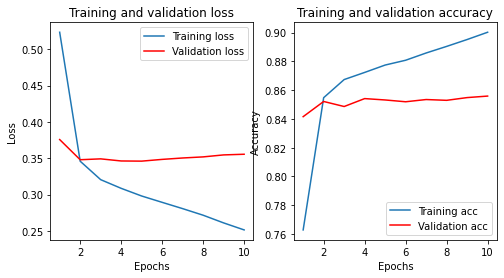

In [19]:
# 모델 성능 시각화

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [20]:
# CNN 모델 설계

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
# CNN 모델 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 3s 6ms/step - loss: 0.4885 - accuracy: 0.7571 - val_loss: 0.3545 - val_accuracy: 0.8440
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3284 - accuracy: 0.8599 - val_loss: 0.3396 - val_accuracy: 0.8530
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2978 - accuracy: 0.8747 - val_loss: 0.3391 - val_accuracy: 0.8532
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2733 - accuracy: 0.8876 - val_loss: 0.3433 - val_accuracy: 0.8548
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2465 - accuracy: 0.9013 - val_loss: 0.3538 - val_accuracy: 0.8511
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2181 - accuracy: 0.9158 - val_loss: 0.3731 - val_accuracy: 0.8475
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.1883 - accuracy: 0.9302 - val_loss: 0.3995 - val_accuracy: 0.8471
Epoch 

In [22]:
# 학습이 끝난 모델 평가

results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.5309 - accuracy: 0.8299
[0.5308759808540344, 0.8298919796943665]


In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


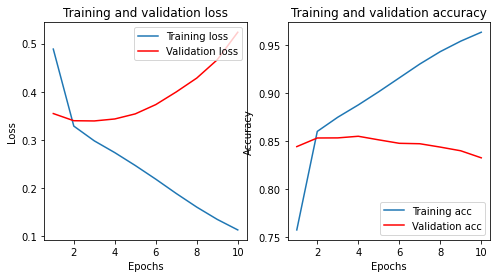

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [25]:
# GlobalMaxPooling1D 모델 설계

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [26]:
# GlobalMaxPooling1D 모델 훈련

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 1s 4ms/step - loss: 0.5839 - accuracy: 0.7220 - val_loss: 0.4366 - val_accuracy: 0.8188
Epoch 2/10
247/247 [==============================] - 1s 3ms/step - loss: 0.3844 - accuracy: 0.8374 - val_loss: 0.3668 - val_accuracy: 0.8378
Epoch 3/10
247/247 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8579 - val_loss: 0.3560 - val_accuracy: 0.8439
Epoch 4/10
247/247 [==============================] - 1s 3ms/step - loss: 0.3063 - accuracy: 0.8718 - val_loss: 0.3545 - val_accuracy: 0.8450
Epoch 5/10
247/247 [==============================] - 1s 3ms/step - loss: 0.2871 - accuracy: 0.8819 - val_loss: 0.3583 - val_accuracy: 0.8448
Epoch 6/10
247/247 [==============================] - 1s 3ms/step - loss: 0.2719 - accuracy: 0.8891 - val_loss: 0.3630 - val_accuracy: 0.8439
Epoch 7/10
247/247 [==============================] - 1s 3ms/step - loss: 0.2594 - accuracy: 0.8948 - val_loss: 0.3691 - val_accuracy: 0.8435
Epoch 

In [27]:
# 모델 평가

results = model.evaluate(x_test,  y_test, verbose=2)
print(results)


1537/1537 - 2s - loss: 0.4035 - accuracy: 0.8386
[0.4034782648086548, 0.8385784029960632]


In [28]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


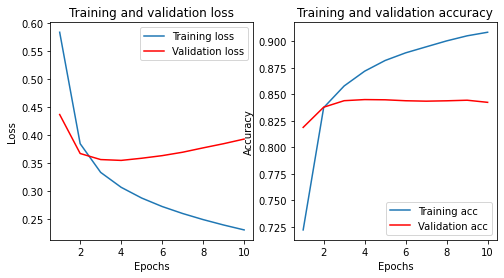

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Step 6. Word2Vec 적용

In [30]:
pip list | grep gensim

gensim                        3.8.3
Note: you may need to restart the kernel to use updated packages.


In [31]:
# embedding layer 확인

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [32]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
# 임베딩 파라미터를 읽어서 word vector로 활용

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.20019801, -0.03005415,  0.04682031, -0.13236313, -0.14758512,
        0.08020398, -0.11186281, -0.14524671, -0.18004024, -0.14228602,
       -0.04864917,  0.0179465 , -0.12341024,  0.0170996 , -0.11228779,
       -0.11492773], dtype=float32)

In [34]:
# 유사도 확인

word_vectors.similar_by_word("사랑")

[('ㅠㅠㅠㅠㅠ', 0.9540506601333618),
 ('원표', 0.9505513906478882),
 ('린다', 0.9290256500244141),
 ('씀', 0.9253398776054382),
 ('기다려', 0.9188269376754761),
 ('일찍', 0.9182313084602356),
 ('찾아가', 0.9167588949203491),
 ('꼽히', 0.9154055118560791),
 ('짤', 0.9153347015380859),
 ('댄', 0.9148435592651367)]

In [36]:
# 한국어 word2Vec 가져오기

import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_path)
vector = ko_model['사랑']
vector.shape

/tmp/ipykernel_432/2745062748.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = ko_model['사랑']


(200,)

In [37]:
# 단어 유사도 확인

ko_model.wv.most_similar("사랑")

[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [38]:
ko_model.wv.most_similar("슬픔")

[('기쁨', 0.7767106294631958),
 ('절망', 0.7710496783256531),
 ('아픔', 0.7430999279022217),
 ('비탄', 0.7297681570053101),
 ('고독', 0.7251476049423218),
 ('사랑', 0.7216662168502808),
 ('외로움', 0.7195188999176025),
 ('추억', 0.6951203346252441),
 ('이별', 0.6873862147331238),
 ('괴로움', 0.6854110956192017)]

In [43]:
# embedding metrix 생성

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수는 ko_model의 vector 차원수 200으로!
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 ko_model 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/tmp/ipykernel_432/2319194447.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_model:
/tmp/ipykernel_432/2319194447.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_model[index_to_word[i]]


In [47]:
# Word2Vec 사용해서 모델 훈련 및 평가 - CNN

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 7ms/step - loss: 0.5840 - accuracy: 0.6514 - val_loss: 0.4454 - val_accuracy: 0.7919
Epoch 2/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3922 - accuracy: 0.8251 - val_loss: 0.3783 - val_accuracy: 0.8323
Epoch 3/10
247/247 [==============================] - 2s 6ms/step - loss: 0.3289 - accuracy: 0.8598 - val_loss: 0.3540 - val_accuracy: 0.8444
Epoch 4/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2942 - accuracy: 0.8770 - val_loss: 0.3543 - val_accuracy: 0.8450
Epoch 5/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2669 - accuracy: 0.8907 - val_loss: 0.3650 - val_accuracy: 0.8454
Epoch 6/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2417 - accuracy: 0.9038 - val_loss: 0.3730 - val_accuracy: 0.8444
Epoch 7/10
247/247 [==============================] - 2s 6ms/step - loss: 0.2216 - accuracy: 0.9131 - val_loss: 0.3873 - val_accuracy: 0.8449
Epoch 

In [48]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4897 - accuracy: 0.8341
[0.4896853268146515, 0.8340826034545898]


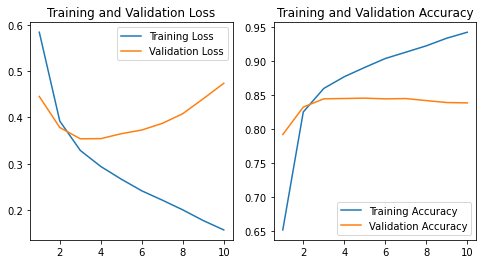

In [49]:
# 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [50]:
# Word2Vec 사용해서 모델 훈련 및 평가 - RNN

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8)) 
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 3s 8ms/step - loss: 0.5040 - accuracy: 0.7473 - val_loss: 0.3852 - val_accuracy: 0.8340
Epoch 2/5
247/247 [==============================] - 2s 6ms/step - loss: 0.3575 - accuracy: 0.8460 - val_loss: 0.3529 - val_accuracy: 0.8475
Epoch 3/5
247/247 [==============================] - 2s 6ms/step - loss: 0.3188 - accuracy: 0.8659 - val_loss: 0.3419 - val_accuracy: 0.8522
Epoch 4/5
247/247 [==============================] - 2s 7ms/step - loss: 0.2963 - accuracy: 0.8771 - val_loss: 0.3435 - val_accuracy: 0.8538
Epoch 5/5
247/247 [==============================] - 2s 7ms/step - loss: 0.2796 - accuracy: 0.8853 - val_loss: 0.3419 - val_accuracy: 0.8548


In [51]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3514 - accuracy: 0.8510
[0.35141560435295105, 0.8509876728057861]


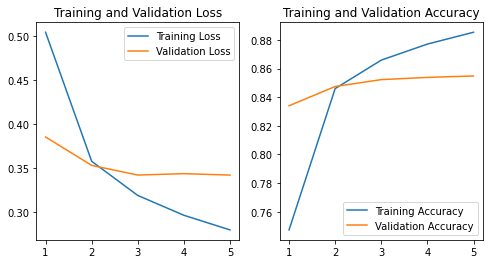

In [52]:
# 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [56]:
# Word2Vec 사용해서 모델 훈련 및 평가 - GlobalMaxPooling1D

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              
epochs=20  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 2s 5ms/step - loss: 0.6532 - accuracy: 0.6199 - val_loss: 0.5918 - val_accuracy: 0.6879
Epoch 2/20
247/247 [==============================] - 1s 4ms/step - loss: 0.5496 - accuracy: 0.7228 - val_loss: 0.5174 - val_accuracy: 0.7465
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.4853 - accuracy: 0.7680 - val_loss: 0.4762 - val_accuracy: 0.7697
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 0.4427 - accuracy: 0.7946 - val_loss: 0.4520 - val_accuracy: 0.7882
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.4112 - accuracy: 0.8136 - val_loss: 0.4269 - val_accuracy: 0.8023
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.3880 - accuracy: 0.8258 - val_loss: 0.4149 - val_accuracy: 0.8091
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 0.3677 - accuracy: 0.8376 - val_loss: 0.4055 - val_accuracy: 0.8145
Epoch 

In [57]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.4319 - accuracy: 0.8226
[0.43189728260040283, 0.8225888609886169]


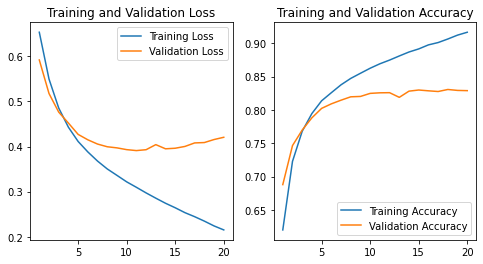

In [58]:
# 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Loss 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### Step 7. 회고

  - 노드에서는 word2Vec을 정상적으로 잘 활용하면 5% 이상의 성능 향상이 발생한다고 하였는데 내가 적용한 모델에서는 word2Vec을 활용해도 정확도의 차이가 크지 않았다.
  - word2Vec을 활용한 모델들에서는 성능 향상을 위해서 epoch를 각각 다르게 설정해서 모델을 돌려보았지만 큰 차이가 없었다.
  - 아무래도 다른 부분을 수정해줘야지 모델 향상을 이끌어 낼 수 있을 것 같다.
  - 아직 이번 프로젝트 노드에 대한 이해가 정확하지 못해서 다른 방법을 통해서 성능 향상을 도전해보지 못한 것은 아쉬운 점으로 남은 것 같다.
  - 특히 gensim을 사용하면서 버전을 다운그레이드 해야하는데 있어서 좀 어려움이 있었다.
  - 분명 다운그레이드를 완료했는데 버전을 확인하면 최신버전으로 확인되어서 아예 셧다운하고 다시 확인했을때 다운그레이드 버전으로 확인되었다.
  - 이번 노드를 끝내긴 했지만 사실 아직 정확한 이해가 되지 않는 부분들이 많다.
  - 단어들도 익숙하지 않고 NLP 노드가 확실히 더 어려운 것 같다는 느낌이다.